# playground: stochastic-geometric 6D pose estimation

In [29]:
from py_session import py_session
# py_session(include_na=False, return_list=False)
import sys
print(sys.version)

py_session()
import os




3.12.0 | packaged by conda-forge | (main, Oct  3 2023, 08:43:22) [GCC 12.3.0]
56 modules found
IPython             	8.16.1                  ipython_genutils    	0.2.0                   psutil              	5.9.6
PIL                 	10.1.0                  ipywidgets          	8.1.2                   ptyprocess          	0.7.0
argparse            	1.1                     jedi                	0.19.1                  pure_eval           	0.2.2
backcall            	0.2.0                   joblib              	1.3.2                   py_session          	0.1.1
cffi                	1.16.0                  json                	2.0.9                   pydevd              	2.9.5
colorama            	0.4.6                   jupyter_client      	8.4.0                   pygments            	2.16.1
comm                	0.1.4                   jupyter_core        	5.4.0                   pyparsing           	3.1.1
csv                 	1.0                     kiwisolver          	1.4.5              

### setup of experiment

In [6]:
 # import modules from source
import os, sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib.pyplot as plt
import numpy as np

features = {
    'p1': np.array([0, -25, -43.30]),
    'p2': np.array([100, -25, -43.30]),
    'p3': np.array([0, 61.60, -93.30]),
    'p4': np.array([100, 111.60, -6.70]),
    'p5': np.array([100, 25, 43.30]),
    'p6': np.array([0, 111.60, -6.70]),
}

features_arr = np.row_stack(list(features.values()))

C = 1000
sensors = {
    's1': np.array([0, -C, 0]),
    's2': np.array([C, 0, 0]),
    's3': np.array([0, 0, C])
}

np.set_printoptions(suppress=True)
np.set_printoptions(formatter={'float': lambda x: "{0:2.6f}".format(x)})

def radar_plot(v1, v2):
    # Number of variables we're plotting.
    num_vars = 6

    # Split the circle into even parts and save the angles
    # so we know where to put each axis.
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The radar chart plots a circle, so we need to "complete the loop"
    # and append the start value to the end for both vectors.
    v1 = np.concatenate((v1,[v1[0]]))
    v2 = np.concatenate((v2,[v2[0]]))
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(3, 3), subplot_kw=dict(polar=True))

    # Draw one axe per variable and add labels
    plt.xticks(angles[:-1], ['delta_x', 'delta_y', 'delta_Z', 'roll', 'pitch', 'yaw'])

    # Draw ylabels
    ax.set_rlabel_position(30)
    plt.yticks([min(np.concatenate((v1,v2))), max(np.concatenate((v1,v2)))], ["Min", "Max"], color="grey", size=7)
    plt.ylim(min(np.concatenate((v1,v2)))-1, max(np.concatenate((v1,v2)))+1)

    # Plot data for the first vector
    ax.plot(angles, v1, linewidth=1, linestyle='solid', label='True')
    ax.fill(angles, v1, alpha=0.25)

    # Plot data for the second vector
    ax.plot(angles, v2, linewidth=1, linestyle='solid', label='Prediction')
    ax.fill(angles, v2, alpha=0.25)

    # Add a legend
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

    # Show the plot
    plt.show()

/tmp/ipykernel_638/2435284294.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(new_x_labels)
/tmp/ipykernel_638/2435284294.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(new_y_labels)
/tmp/ipykernel_638/2435284294.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_zticklabels(new_z_labels)


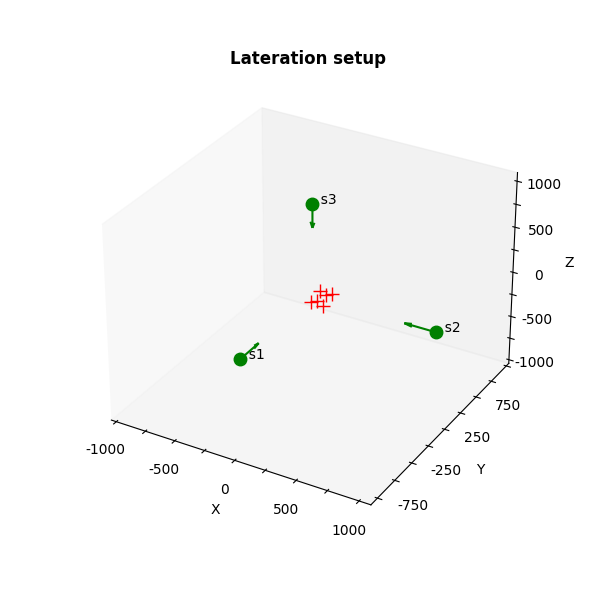

In [8]:
%matplotlib widget

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

# plot feature points
for label, (x,y,z) in features.items():
    ax.plot(x,y,z, "+", markersize=10, label=label, color="r")
    # ax.text(x,y,z, label)

# plot sensors
for i, (label, sensor_pos) in enumerate(sensors.items()):
    x, y, z = sensor_pos
    ax.plot(x,y,z, ".", markersize=18, label=label, color="g")
    ax.text(x,y,z, "  "+ label)
    sensor_vec = np.zeros(3) - sensor_pos
    ax.quiver(*sensor_pos, *sensor_vec, length=0.25, linewidths=1.5, color='green', arrow_length_ratio=0.25)

# plot data points
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Lateration setup' , weight='bold')

# ax.set_xlim([-100, C])
# ax.set_ylim([-C, C-900])
# ax.set_zlim([-C+750, C+50])

ax.set_xlim([-C, C+50])
ax.set_ylim([-C-50, C])
ax.set_zlim([-C, C+50])
ax.grid(False)

# Get current labels
x_labels = plt.gca().get_xticks()
y_labels = plt.gca().get_yticks()
z_labels = plt.gca().get_zticks()

# Keep every other label
new_x_labels = [int(label) if i % 2 == 0 else '' for i, label in enumerate(x_labels)]
new_y_labels = [int(label) if i % 2 == 0 else '' for i, label in enumerate(y_labels)]
new_z_labels = [int(label) if i % 2 == 0 else '' for i, label in enumerate(z_labels)]

# Set new labels
plt.gca().set_xticklabels(new_x_labels)
plt.gca().set_yticklabels(new_y_labels)
plt.gca().set_zticklabels(new_z_labels)

plt.show()

### observation function for lateration

In [9]:
from scipy.spatial.transform import Rotation
    
# rigid body transformation x,y,z-axis
def p1_xyz(z, alpha, w):
    R_x = Rotation.from_euler('x', alpha[0])
    R_y = Rotation.from_euler('y', alpha[1])
    R_z = Rotation.from_euler('z', alpha[2])
    return R_z.apply(R_y.apply(R_x.apply(z + w)))

    # R_zyx = Rotation.from_euler('xyz', alpha)
    # return R_zyx.apply(z+w)
    
# observational function of multilateration
def p2(z, alpha, w, gamma):
    u = p1_xyz(z, alpha, w)
    return np.linalg.norm(u-gamma)

### Forward model (true distances):

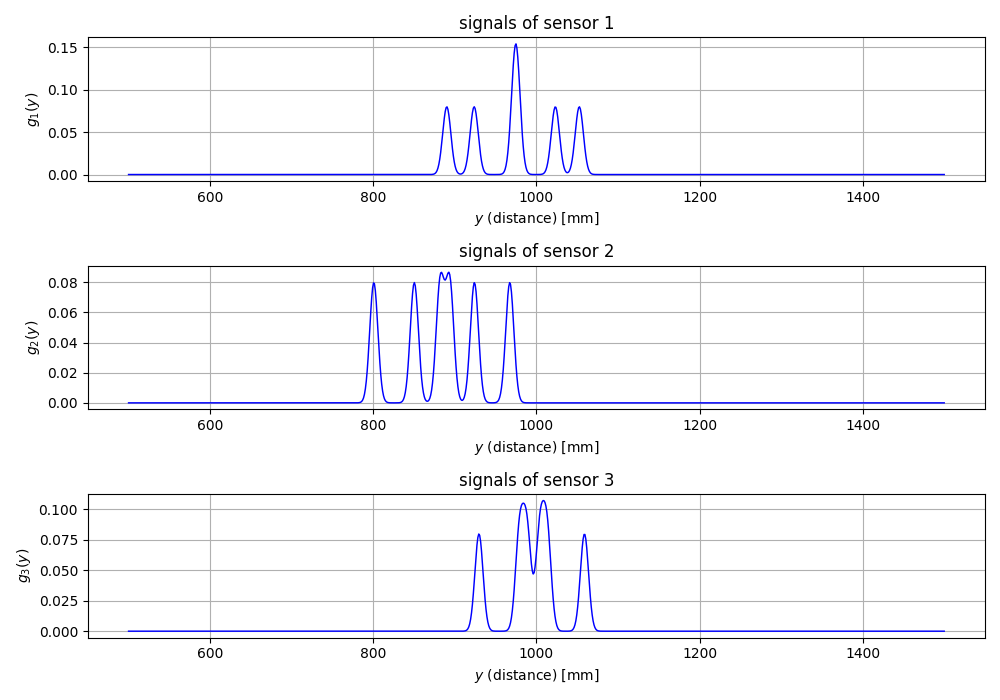

In [10]:
from scipy import interpolate

w0 = np.zeros(3)
V0 = np.zeros(3)

delta_w = np.ones(3)*40
alpha = np.array([0, 0, -np.pi*(4/12)])

w0 = w0 + delta_w
V0 = V0 + alpha

# V0 = np.array([-1.57079633, 0.52361148, 0])
# w0 = np.array([0.0, 111.6,-6.7])

points = np.array(list(features.values()))
points_new = points.copy()
    
# plot sensor data
plt.figure(figsize=(10, 7))

g_pdfs = []

for i, (slabel, sensor_pos) in enumerate(sensors.items()):

    distances = []
    for p in points_new:
        distances.append(p2(p, V0, w0, sensor_pos))

    x = np.linspace(500, 1500, 900)
    y = np.zeros_like(x)
    sigma = 5
        
    for d in distances:
        # add a gaussian kernel for each distance
        gaussian_norm_const  = 1/(np.sqrt(2*np.pi)*sigma)
        y += gaussian_norm_const  * np.exp(-((x - d)**2) / (2 * sigma**2))

    g_pdfs.append(interpolate.interp1d(x, y, kind="cubic"))# fill_value="extrapolate")) #)  #
    
    # add a subplot for the current sensor
    plt.subplot(len(sensors), 1, i+1)
    plt.plot(x, y, color='b', linewidth=1.05)
    plt.title(f"signals of sensor {i+1}")
    plt.xlabel(fr'$y$ (distance) [mm]')
    plt.ylabel(fr'$g_{i+1}(y)$')
    plt.grid(True)

plt.tight_layout()
plt.show()


### feature coordinate mixture model

### lhsnorm

In [19]:
from scipy.stats import qmc, norm

def lhsnorm(mean, std, size):
    num_samples, dim = size

    sampler = qmc.LatinHypercube(d=dim, optimization="random-cd").random(n=num_samples)
    samples_norm = norm(loc=mean, scale=std).ppf(sampler)
    
    return samples_norm

In [18]:
def q(z, std, R, lhs_on=False):
    if lhs_on:
        z_samples = lhsnorm(z, std, size=(R, z.shape[0]))
    else:
        z_samples = np.random.normal(z, std, size=(R, z.shape[0]))
    
    if (z_samples.shape[0] == 1):
        return z_samples[0]
    
    return z_samples


In [17]:
q(np.ones(3)*5, 1, 1, lhs_on=True)

NameError: name 'q' is not defined

In [11]:
list(zip(features.keys(), np.row_stack(list(features.values()))))

[('p1', array([0.000000, -25.000000, -43.300000])),
 ('p2', array([100.000000, -25.000000, -43.300000])),
 ('p3', array([0.000000, 61.600000, -93.300000])),
 ('p4', array([100.000000, 111.600000, -6.700000])),
 ('p5', array([100.000000, 25.000000, 43.300000])),
 ('p6', array([0.000000, 111.600000, -6.700000]))]

### drawing R measurements from mixture model

In [20]:
# sample measurements for each feature point
points = np.row_stack(list(features.values()))

sampled_feature_pnts = {}
R = 500
std = 10
for feature_label, feature_coords in zip(features.keys(), points):
# for feature_label, feature_coords in features.items():
    sampled_feature_pnts[feature_label] = q(feature_coords, std, R, lhs_on=True)

N = len(sampled_feature_pnts)

print((N, R))
sampled_feature_pnts

(6, 500)


{'p1': array([[-15.689060, -14.270375, -36.386443],
        [1.202944, -43.483338, -47.530428],
        [13.204779, -54.452839, -45.516588],
        ...,
        [3.431827, -35.300018, -47.626680],
        [-7.413317, -51.190845, -31.308222],
        [5.180334, -25.056489, -46.529979]]),
 'p2': array([[94.818273, -16.732264, -27.871827],
        [94.872654, -25.156847, -30.247852],
        [108.155035, -15.731861, -54.561804],
        ...,
        [98.780245, 12.041950, -25.823280],
        [104.258203, -21.512107, -32.239988],
        [105.518138, -18.831917, -37.253785]]),
 'p3': array([[13.351123, 66.945410, -93.747899],
        [0.888743, 45.749234, -80.739433],
        [-14.694501, 67.430684, -114.702547],
        ...,
        [16.298260, 45.980425, -82.696212],
        [-0.031169, 62.234024, -94.860562],
        [7.009980, 52.843757, -114.844716]]),
 'p4': array([[93.620640, 120.983207, 3.777720],
        [91.851333, 117.004486, -10.646683],
        [111.541209, 112.976390, 4.181

In [21]:
sensors_arr= np.array(list(sensors.values()))
sampled_features_arr = np.array(list(sampled_feature_pnts.values()))

# cost function
def f_cost(x0, *args):
    V, w = x0.reshape(2,3)
    cost_sum = 0.0
    
    # number of features N
    for _, samples_arr in sampled_feature_pnts.items():
        
        # number of samples per features R
        for z_vec in samples_arr:
            inner_product = 1.0
            
            # number of lateration devices L
            for sensor_idx, sensor_coords in enumerate(sensors.values()):
                inner_product *= g_pdfs[sensor_idx](p2(z_vec, V, w, sensor_coords))
                
            cost_sum += inner_product
    
    return cost_sum / (N*R)

# cost function
def f_cost_new(x0, *args):
    V, w = x0.reshape(2,3)
    cost_sum = 0.0
        
    # number of features N
    for samples_arr in sampled_features_arr:
        # number of samples per features R
        for z_vec in samples_arr:
            sensor_product = np.prod([g_pdfs[l](p2(z_vec, V, w, sensors_arr[l])) for l in range(sensors_arr.shape[0])])
            cost_sum += sensor_product
    
    return cost_sum / (N*R)

### Nelder-Mead

In [24]:
true_pose = np.concatenate((V0, w0))

V_guess = q(V0, np.pi*(1/72), 1)
w_guess = q(w0, 5, 1)

In [23]:
from scipy.optimize import minimize

def f_nm_cost_wrapper(x0):
    return -f_cost(x0)


x0 = np.concatenate((V_guess, w_guess))
alpha_opt = minimize(f_nm_cost_wrapper, x0, method='Nelder-Mead', tol=10e-6)
alpha_opt.x

print("%s"%str(true_pose))  # real pose
print(x0)                   # perturbed pose
print(alpha_opt.x)

a, b = x0.reshape(2,3)

KeyboardInterrupt: 

In [20]:
print(str(abs(alpha_opt.x - true_pose)) + ". RMS: " + str(np.mean(np.sqrt((alpha_opt.x - true_pose)**2))))# predicted pose

[0.025453 0.026994 0.021198 1.267090 1.375209 0.093703]. RMS: 0.4682745084037087
0.7645613943364815


### Bayesian Optimization

In [25]:
# draw guess pose for inital value of optimization
# true_pose = np.concatenate([V0, w0])

dV_max = np.pi*(1/72)   # 5 degrees
dw_max = 5              # 5 mm

# V_probe = V0 + np.random.uniform(low=-dV_max, high=dV_max, size=3)
# w_probe = w0 + np.random.uniform(low=-dw_max, high=dw_max, size=3)

x0_probe = np.concatenate([V_guess, w_guess])
x0_probe

array([-0.044415, -0.007528, -1.005192, 36.130801, 42.698448, 42.046680])

In [19]:
# draw guess pose for inital value of optimization
true_pose = np.concatenate([V0, w0])

true_dV_max = np.pi*(1/36)   # 2.5 degrees
true_dw_max = 5              # 5 mm

dV_max = np.pi*(1/72)   # 5 degrees
dw_max = 5              # 5 mm

V_probe = V0 + np.random.uniform(low=-true_dV_max, high=true_dV_max, size=3)
w_probe = w0 + np.random.uniform(low=-true_dw_max, high=true_dw_max, size=3)

x0_probe = np.concatenate([V_probe, w_probe])
x0_probe

array([0.030814, -0.070818, -1.126596, 44.924526, 41.021822, 39.919836])

In [26]:
from bayes_opt import BayesianOptimization
from bayes_opt import SequentialDomainReductionTransformer
from bayes_opt import UtilityFunction

# define bounds
pbounds = {}
for i in range(len(V0)):
    pbounds[f'V{i}'] = (V0[i]-dV_max, V0[i]+dV_max)
for i in range(len(w0)):
    pbounds[f'w{i}'] = (w0[i]-dw_max, w0[i]+dw_max)

bounds_transformer = SequentialDomainReductionTransformer(minimum_window=dV_max/3)

# wrapper function to convert input to numpy array
def f_cost_wrapper(V0, V1, V2, w0, w1, w2):
    return f_cost(np.array([V0, V1, V2, w0, w1, w2]))

# create optimizer object
optimizer = BayesianOptimization(f=f_cost_wrapper, pbounds=pbounds, random_state=1, bounds_transformer=bounds_transformer)
optimizer.probe(params=dict(zip(['V0', 'V1', 'V2', 'w0', 'w1', 'w2'], x0_probe)), lazy=True)

In [20]:
from bayes_opt import BayesianOptimization
from bayes_opt import SequentialDomainReductionTransformer
from bayes_opt import UtilityFunction

# define bounds
pbounds = {}
for i in range(len(V_probe)):
    pbounds[f'V{i}'] = (V_probe[i]-dV_max, V_probe[i]+dV_max)
for i in range(len(w_probe)):
    pbounds[f'w{i}'] = (w_probe[i]-dw_max, w_probe[i]+dw_max)

bounds_transformer = SequentialDomainReductionTransformer(minimum_window=dV_max/3)

# wrapper function to convert input to numpy array
def f_cost_wrapper(V0, V1, V2, w0, w1, w2):
    return f_cost(np.array([V0, V1, V2, w0, w1, w2]))

# create optimizer object
optimizer = BayesianOptimization(f=f_cost_wrapper, pbounds=pbounds, random_state=1, bounds_transformer=bounds_transformer)
# optimizer.probe(params=dict(zip(['V0', 'V1', 'V2', 'w0', 'w1', 'w2'], x0_probe)), lazy=True)

In [22]:
acquisition_function = UtilityFunction(kind="ucb")#xi=0.1)#, kappa_decay=0.5)
optimizer.maximize(init_points=18, n_iter=100, acquisition_function=acquisition_function)

best_params = optimizer.max['params']
best_alpha = np.array(list(best_params.values()))
print(best_alpha)

|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 1         | 7.417e-05 | -0.009089 | 0.0524    | -0.9695   | 52.84     | 40.01     | 42.94     |
| 2         | 8.965e-05 | -0.007241 | 0.01923   | -1.091    | 38.02     | 36.47     | 35.92     |
| 3         | 0.0001213 | -0.02738  | -0.01348  | -1.056    | 40.39     | 39.19     | 41.85     |
| 4         | 9.532e-05 | -0.02579  | 0.033     | -1.088    | 41.7      | 39.17     | 40.59     |
| 5         | 0.0001139 | -0.03138  | -0.02635  | -1.021    | 44.68     | 38.13     | 41.92     |
| 6         | 9.177e-05 | 0.03285   | 0.03444   | -1.083    | 35.39     | 36.7      | 43.78     |
| 7         | 9.295e-05 | -0.03505  | -0.006885 | -1.007    | 40.33     | 41.92     | 38.16     |
| 8         | 9.945e-05 | 0.01628   | 0.0292    | -1.089    | 42.5      | 44.89     | 42.48     |
| 9         | 0.0001

In [ ]:
acquisition_function = UtilityFunction(kind="ei", xi=0)
optimizer.maximize(init_points=200, n_iter=50, acquisition_function=acquisition_function)
best_params = optimizer.max['params']
best_alpha = np.array(list(best_params.values()))
print(best_alpha)

In [23]:
print(" True:  " + str(true_pose))
# print("Guess:  " + str(np.concatenate((V_probe, w_probe))) + ". RMS: " + str(np.mean(np.sqrt((x0_probe - true_pose)**2))))
print(" Best:  " + str(best_alpha) + ". RMS: " + str(np.mean(np.sqrt((best_alpha - true_pose)**2))))
print(f"Error:  {np.abs(true_pose - best_alpha)}")

 True:  [0.000000 0.000000 -1.047198 40.000000 40.000000 40.000000]
 Best:  [-0.027928 -0.022527 -1.064590 39.211424 40.838347 40.664136]. RMS: 0.3931510576782948
Error:  [0.027928 0.022527 0.017392 0.788576 0.838347 0.664136]


In [24]:
# best_alpha = np.concatenate([best_V, best_w])
best_alpha_deg = np.concatenate([best_alpha[:3]*(180/np.pi), best_alpha[3:]])
true_pose_deg = np.concatenate([true_pose[:3]*(180/np.pi), true_pose[3:]])

print(" True: " + str(true_pose_deg))
print(" Best: " + str(best_alpha_deg) + ". RMS: " + str(np.mean(np.sqrt((best_alpha_deg - true_pose_deg)**2))))

 True: [0.000000 0.000000 -60.000000 40.000000 40.000000 40.000000]
 Best: [-1.600150 -1.290693 -60.996497 39.211424 40.838347 40.664136]. RMS: 1.0297331827194818


In [25]:
from matplotlib import gridspec

# draw guess pose for inital value of optimization
true_pose = np.concatenate([V0, w0])

dV_max = np.pi*(1/36)   # 2.5 degrees
dw_max = 10             # 5 mm

V_probe = V0 + np.random.uniform(low=-dV_max, high=dV_max, size=3)
w_probe = w0 + np.random.uniform(low=-dw_max, high=dw_max, size=3)

x0_probe = np.concatenate([V_probe, w_probe])

# define bounds
pbounds = {}
lower_bound = w_probe[i]-dw_max
# for i in range(len(V_probe)):
#     pbounds[f'V{i}'] = (V_probe[i]-dV_max, V_probe[i]+dV_max)
for i in range(len(w_probe)):
    if i == 0:
        pbounds[f'w{i}'] = (w_probe[i]-dw_max, w_probe[i]+dw_max)

bounds_transformer = SequentialDomainReductionTransformer(minimum_window=dV_max/3)

# wrapper function to convert input to numpy array
def f_cost_wrapper(w0):
    return f_cost(np.array([true_pose[0], true_pose[1], true_pose[2], w0, true_pose[4], true_pose[5]]))

acq_function = UtilityFunction(kind="ucb")

# create optimizer object
optimizer = BayesianOptimization(f=f_cost_wrapper, pbounds=pbounds, random_state=1)

# w_probes = lhs(1, 10, low=40-dw_max, high=40+dw_max)
# for probe in w_probes:
#     print(probe)
#     optimizer.probe(params=dict(zip(['w0'], [probe])), lazy=True)

optimizer.maximize(init_points=1, n_iter=1, acquisition_function = acq_function)


|   iter    |  target   |    w0     |
-------------------------------------
| 1         | 0.0001198 | 39.03     |


KeyboardInterrupt: 

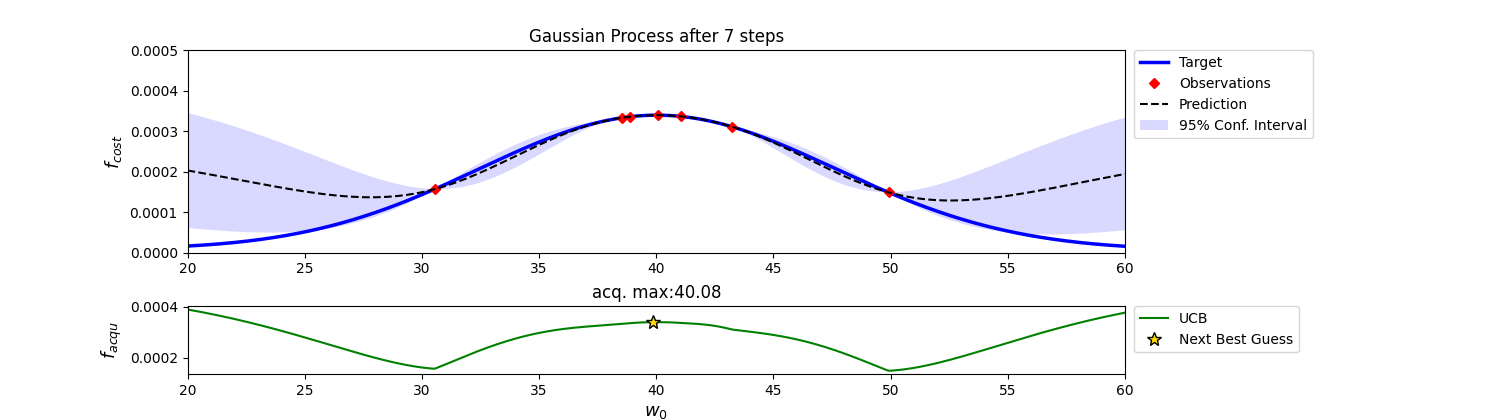

In [332]:

def f_cost_acqu(w0):
    return f_cost(np.array([true_pose[0], true_pose[1], true_pose[2], w0, true_pose[4], true_pose[5]]))

def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)

    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, x_acqu, y_acqu):
    max_val = optimizer.max['params']['w0']
    
    fig = plt.figure(figsize=(15, 4.2))
    steps = len(optimizer.space)
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    # gs = gridspec.GridSpec(1, 1) 
    axis = plt.subplot(gs[0])
    axis.set_title('Gaussian Process after {} steps'.format(steps))
        
    acq = plt.subplot(gs[1])
    fig.subplots_adjust(hspace=0.4)
    
    acq.set_title(f'acq. max:{max_val:.2f}')

    
    x_obs = np.array([[res["params"]["w0"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    
    mu, sigma = posterior(optimizer, x_obs, y_obs, x_acqu)
    axis.plot(x_acqu, y_acqu, linewidth=2.5, color='b', label='Target')
    axis.plot(x_obs.flatten(), y_obs, 'D', markersize=5.5, label=u'Observations', color='r')
    axis.plot(x_acqu, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x_acqu, x_acqu[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.15, fc='b', ec='None', label='95% Conf. Interval')
    
    axis.set_xlim((x_acqu[0], x_acqu[-1]))
    axis.set_ylim((0.0000, 0.00050))
    axis.set_ylabel(r'$f_{cost}$', fontdict={'size':13})
    # axis.set_xlabel(r'$w_0$', fontdict={'size':13})
    
    # re-add acqu plot for next sampling point
    
    utility_function = UtilityFunction(kind="ucb")# kappa=10, xi=0)
    utility = utility_function.utility(x_acqu, optimizer._gp, 0)
    acq.plot(x_acqu, utility, label='UCB', color='green')
    acq.plot(x_acqu[150 + np.argmax(utility[150:-100])], np.max(utility[150:-100]), '*', markersize=10, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    # acq.plot(max_val, np.max(utility), '*', markersize=10, 
    #          label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)

    acq.set_xlim((x_acqu[0], x_acqu[-1]))
    # acq.set_yticks([0.0001, 0.0002, 0.0003])
    # acq.set_ylim((np.min(utility- 0.000020), np.max(utility+ 0.000020)))
    acq.set_ylabel(r'$f_{acqu}$', fontdict={'size':13})
    acq.set_xlabel(r'$w_0$', fontdict={'size':13})
    
    fig.subplots_adjust(right=0.75)  # Adjust as necessary
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

# x_acqu = np.linspace(20, 60, 500).reshape(-1, 1)
# x_acqu = x_acqu.T.flatten()
# y_acqu = np.array([f_cost_acqu(w) for w in x_acqu])

plot_gp(optimizer, x_acqu.reshape(-1, 1), y_acqu.reshape(-1, 1))

|   iter    |  target   |    w0     |
-------------------------------------
| 3         | 0.0003332 | 38.52     |


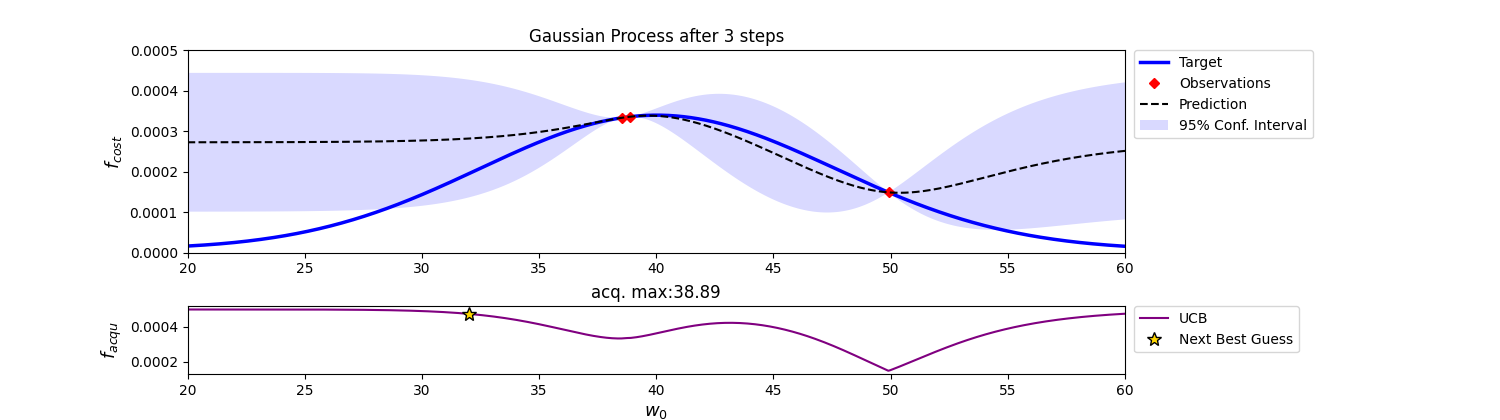

In [324]:
optimizer.maximize(init_points=0, n_iter=1, acquisition_function = acq_function)
plot_gp(optimizer, x_acqu.reshape(-1, 1), y_acqu.reshape(-1, 1))

|   iter    |  target   |    w0     |
-------------------------------------
| 4         | 0.0001569 | 30.55     |


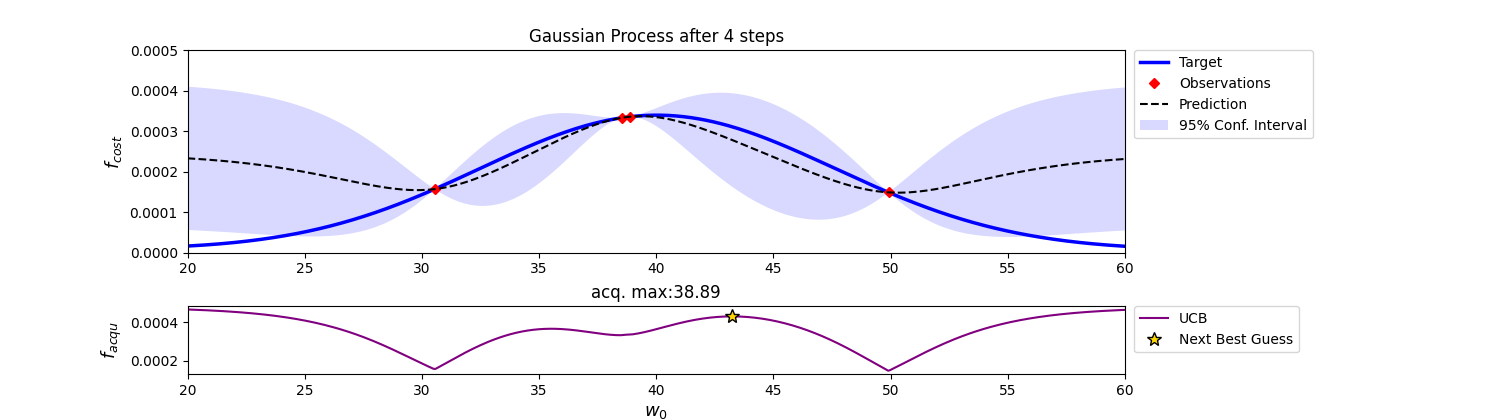

In [325]:
optimizer.maximize(init_points=0, n_iter=1, acquisition_function = acq_function)
plot_gp(optimizer, x_acqu.reshape(-1, 1), y_acqu.reshape(-1, 1))

|   iter    |  target   |    w0     |
-------------------------------------
| 5         | 0.0003111 | 43.23     |


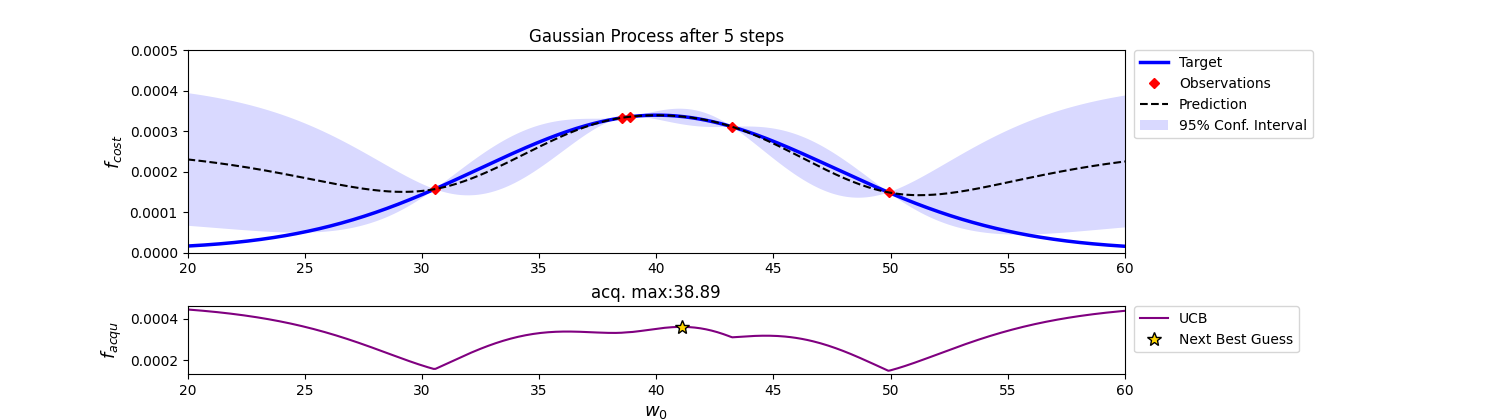

In [326]:
optimizer.maximize(init_points=0, n_iter=1, acquisition_function = acq_function)
plot_gp(optimizer, x_acqu.reshape(-1, 1), y_acqu.reshape(-1, 1))

|   iter    |  target   |    w0     |
-------------------------------------
| 6         | 0.0003366 | 41.08     |


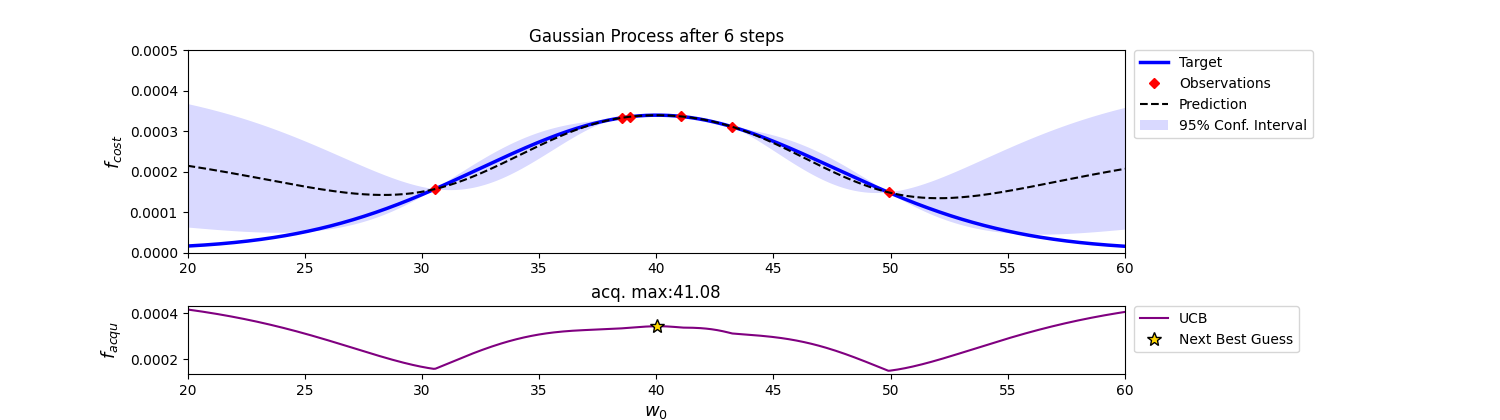

In [327]:
optimizer.maximize(init_points=0, n_iter=1, acquisition_function = acq_function)
plot_gp(optimizer, x_acqu.reshape(-1, 1), y_acqu.reshape(-1, 1))

|   iter    |  target   |    w0     |
-------------------------------------
| 7         | 0.0003398 | 40.08     |


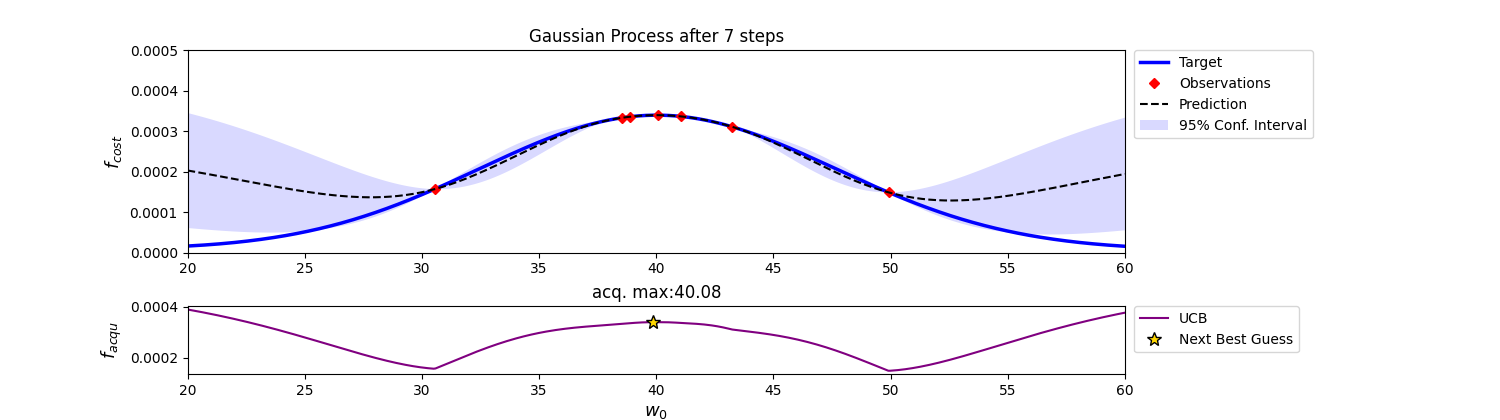

In [328]:
optimizer.maximize(init_points=0, n_iter=1, acquisition_function = acq_function)
plot_gp(optimizer, x_acqu.reshape(-1, 1), y_acqu.reshape(-1, 1))

|   iter    |  target   |    w0     |
-------------------------------------
| 8         | 0.0003398 | 39.92     |


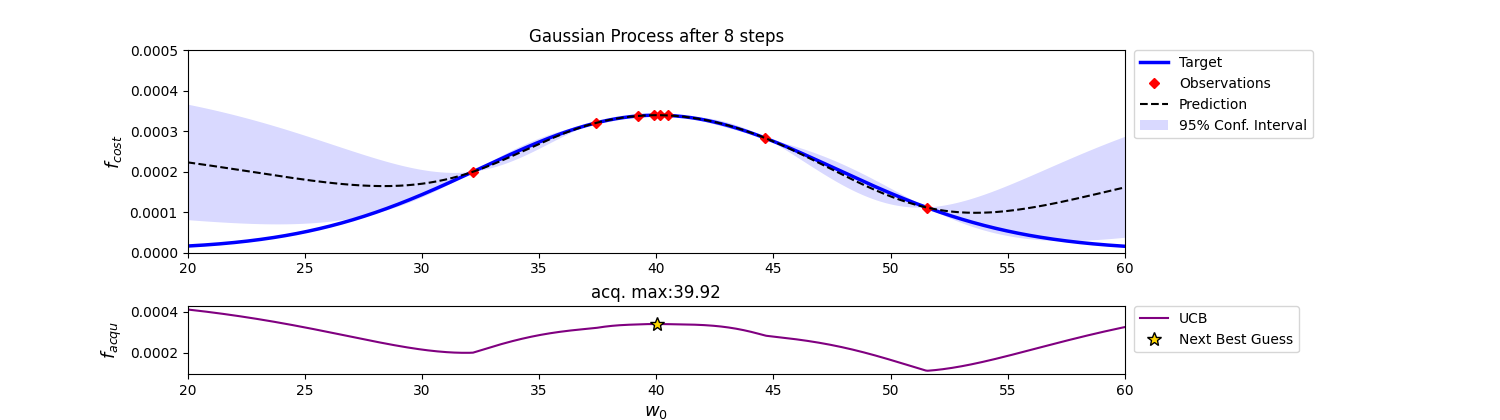

In [321]:
optimizer.maximize(init_points=0, n_iter=1, acquisition_function = acq_function)
plot_gp(optimizer, x_acqu.reshape(-1, 1), y_acqu.reshape(-1, 1))

In [55]:
optimizer.max['params']

{'w0': 39.99334172415097}

In [ ]:
import numpy as np
from scipy.optimize import minimize

def approximate_gradient(f, x, h_rad=np.pi*(1/144), h_mm=1e-3):
    """
    Approximate the gradient of the cost function f at point x.
    """
    grad = np.zeros_like(x)
    for i in range(3):
        x_plus_h = np.copy(x)
        x_plus_h[i] += h_rad
        grad[i] = (f(x_plus_h) - f(x)) / h_rad
        
    for i in range(3, 6):
        x_plus_h = np.copy(x)
        x_plus_h[i] += h_mm
        grad[i] = (f(x_plus_h) - f(x)) / h_mm
        
    return grad

def quasi_newton_method(f, x0, tol=1e-5, max_iter=100):
    """
    Quasi-Newton optimization using BFGS.
    """
    # wrapper for gradient approximation
    def grad_approx(x):
        return approximate_gradient(f, x)
    
    res = minimize(f, x0, method='L-BFGS-B', jac=grad_approx, options={'gtol': tol, 'maxiter': max_iter, 'disp': True})
    # res = minimize(f, x0, method='BFGS', options={'gtol': tol, 'maxiter': max_iter, 'disp': True, 'eps':np.array([0.01, 0.01, 0.01, 0.1, 0.1, 0.1])})
    
    return res

res_bfgs = quasi_newton_method(f_cost, best_alpha)

print("Optimization Result:")
print("Location of Minimum:", res_bfgs.x)
print("Minimum Value:", res_bfgs.fun)


In [27]:
best_opt_deg = np.round(np.concatenate([res_bfgs.x[:3]*(180/np.pi), res_bfgs.x[3:]]), 9)

print(" True: " + str(true_pose_deg))
print(" Best: " + str(best_alpha_deg) + ". RMS: " + str(np.mean(np.sqrt((best_alpha_deg - true_pose_deg)**2))))
print("  Opt: " + str(best_opt_deg) + ". RMS: " + str(np.mean(np.sqrt((best_opt_deg - true_pose_deg)**2))))

 True: [0.000000 0.000000 -60.000000 40.000000 40.000000 40.000000]
 Best: [0.126715 -1.185394 -61.123486 38.287018 41.754968 38.745977]. RMS: 1.1929280466704608
  Opt: [17.171101 11.698188 -21.154021 38.289013 41.751294 38.749544]. RMS: 12.071334089333334


In [ ]:
# test plot of cost function

k=2
# for k in range(3):

# define ranges for V0 and w0
V_range = np.linspace(-2.5, 2.5, 50)
w_range = np.linspace(-50, 150, 50)

# initialize cost surface
cost_surface = np.zeros((len(V_range), len(w_range)))
V, w = V0.copy(), w0.copy()
x0 = np.concatenate((V, w))

# calculate the cost for each combination of V0 and w0
for i, V_ in enumerate(V_range):
    for j, w_ in enumerate(w_range):
        x0[k], x0[k+3] = V_, w_
        cost_surface[i, j] = f_cost(x0)

# from scipy.interpolate import interp2d
from scipy.interpolate import RegularGridInterpolator

# interp_func = interp2d(V_range, w_range, cost_surface.T, kind='cubic')
interp_func = RegularGridInterpolator((V_range, w_range), cost_surface, bounds_error=False, fill_value=None)
alpha_opt_z = interp_func((alpha_opt.x[:3][k], alpha_opt.x[3:][k]))
res_bfgs_z = interp_func((res_bfgs.x[:3][k], res_bfgs.x[3:][k]))
true_pose_z = interp_func((true_pose[:3][k], true_pose[3:][k]))
bayes_z = interp_func((best_alpha[:3][k], best_alpha[3:][k]))

# plotting the cost surface
V_mesh, w_mesh = np.meshgrid(V_range, w_range)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

# ax.scatter(alpha_opt.x[:3][1], alpha_opt.x[3:][1], alpha_opt_z, color='red', s=100, marker='x')
# ax.scatter(true_pose[:3][1], true_pose[3:][1], true_pose_z, color='green', s=100, marker='x')
ax.plot(alpha_opt.x[:3][k], alpha_opt.x[3:][k], alpha_opt_z, color='red', marker='x', markersize=10, zorder=100)
ax.plot(res_bfgs.x[:3][k], res_bfgs.x[3:][k], res_bfgs_z, color='black', marker='x', markersize=10, zorder=100)
ax.plot(true_pose[:3][k], true_pose[3:][k], true_pose_z, color='magenta', marker='x', markersize=10, zorder=100)
ax.plot(best_alpha[:3][k], best_alpha[3:][k], bayes_z, color='cyan', marker='x', markersize=10, zorder=100)

ax.plot_surface(V_mesh, w_mesh, cost_surface.T, cmap='viridis')

ax.set_xlabel('V')
ax.set_ylabel('w')
ax.set_zlabel('Cost Sum')
ax.view_init(azim=-90, elev=90)
plt.title('Cost Function')

plt.show()

In [13]:
# from scipy.interpolate import interp2d

# fig, axes = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(18, 6))

# for k in [0, 1, 2]:

#     # define ranges for V0 and w0
#     Vk_range = np.linspace(-2.5, 2.5, 50)
#     wk_range = np.linspace(-50, 150, 50)

#     # initialize cost surface
#     cost_surface = np.zeros((len(Vk_range), len(wk_range)))

#     # calculate cost for each combination of V0 and w0
#     for i, Vk_ in enumerate(Vk_range):
#         for j, wk_ in enumerate(wk_range):
#             V, w = V0.copy(), w0.copy()
#             V[k], w[k] = Vk_, wk_

#             x0 = np.concatenate((V, w))
#             cost_surface[i, j] = f_cost(x0)

#     # interpolate markers
#     interp_func = interp2d(Vk_range, wk_range, cost_surface.T, kind='cubic')
#     # alpha_opt_z = interp_func(alpha_opt.x[:3][k], alpha_opt.x[3:][k])[0]
#     true_pose_z = interp_func(true_pose[:3][k], true_pose[3:][k])[0]
#     bayes_z = interp_func(best_alpha[:3][k], best_alpha[3:][k])[0]
    
    
#     # plot cost surface
#     V_mesh, w_mesh = np.meshgrid(Vk_range, wk_range)
#     axes[k].plot_surface(V_mesh, w_mesh, cost_surface.T, cmap='viridis', alpha=0.9)

#     # plot markers
#     # axes[k].plot(alpha_opt.x[:3][k], alpha_opt.x[3:][k], alpha_opt_z, color='red', marker='x', markersize=10, zorder=100)
#     axes[k].plot(true_pose[:3][k], true_pose[3:][k], true_pose_z, color='magenta', marker='x', markersize=10, zorder=100)
#     axes[k].plot(best_alpha[:3][k], best_alpha[3:][k], bayes_z, color='cyan', marker='x', markersize=10, zorder=100)

#     axes[k].set_xlabel('V')
#     axes[k].set_ylabel('w')
#     axes[k].set_zlabel('Cost Sum')
#     axes[k].set_title(f'Cost Function for k={k}')

# plt.tight_layout()
# plt.show()

In [27]:
from scipy.interpolate import RegularGridInterpolator
from multiprocessing import Process, Queue

# reduced and slightly blurred sampling for surface plots
sampled_features_surf = {}
R = 50
std = 10
for feature_label, feature_coords in features.items():
    sampled_features_surf[feature_label] = q(feature_coords, std, R, lhs_on=True)

N = len(sampled_feature_pnts)

# cost function for surface plot using reduced samples
def f_cost_surf(x0, *args):
    V, w = x0.reshape(2,3)
    cost_sum = 0.0
    
    # number of featrues N
    for _, samples_arr in sampled_features_surf.items():
        
        # number of samples per features R
        for z_vec in samples_arr:
            inner_product = 1.0
            
            # number of lateration devices L
            for sensor_idx, sensor_coords in enumerate(sensors.values()):
                inner_product *= g_pdfs[sensor_idx](p2(z_vec, V, w, sensor_coords))
                
            cost_sum += inner_product
    
    return cost_sum / (N*R)

# computes cost surface for given k
def compute_cost_surface(k, V0, w0, f_cost, alpha_opt, true_pose, best_alpha, guess, output):
    # V_range = np.linspace(-2.5, 2.5, 50)
    # w_range = np.linspace(-50, 150, 50)
    V_range = np.linspace(-1, 1, 50)
    w_range = np.linspace(0, 100, 50)
    if k==2:
        V_range = np.linspace(-2, 0, 50)
        w_range = np.linspace(-20, 80, 50)

    # initialize cost surface
    cost_surface = np.zeros((len(V_range), len(w_range)))
    V, w = V0.copy(), w0.copy()
    x0 = np.concatenate((V, w))

    # calculate cost for each combination of V0 and w0
    for i, V_ in enumerate(V_range):
        for j, w_ in enumerate(w_range):
            x0[k], x0[k+3] = V_, w_
            cost_surface[i, j] = f_cost_surf(x0)

    # interp_func = interp2d(V_range, w_range, cost_surface.T, kind='cubic')
    interp_func = RegularGridInterpolator((V_range, w_range), cost_surface, bounds_error=False, fill_value=None)
    
    alpha_opt_z = interp_func((alpha_opt.x[:3][k], alpha_opt.x[3:][k]))
    true_pose_z = interp_func((true_pose[:3][k], true_pose[3:][k]))
    bayes_z = interp_func((best_alpha[:3][k], best_alpha[3:][k]))
    guess_z = interp_func((guess[:3][k], guess[3:][k]))

    # put results in output queue
    output.put((k, cost_surface, alpha_opt_z, true_pose_z, bayes_z, guess_z))

# create queue to share results
output = Queue()
processes = []

for k in range(3):
    p = Process(target=compute_cost_surface, args=(k, V0, w0, f_cost, alpha_opt, true_pose, best_alpha, x0_probe, output))
    processes.append(p)
    p.start()

# wait for processes to complete
for p in processes:
    p.join()

results = [output.get() for _ in range(3)]

from matplotlib.ticker import FuncFormatter
def custom_format(x, pos):
    return f'{x:.1f}' 

# plot results
fig, axes = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(16, 6))
for result in sorted(results):
    k, cost_surface, alpha_opt_z, true_pose_z, bayes_z, guess_z = result
    
    # interpolate and plot cost surface
    # V_range = np.linspace(-2.5, 2.5, 50)
    # w_range = np.linspace(-50, 150, 50)
    V_range = np.linspace(-1, 1, 50)
    w_range = np.linspace(0, 100, 50)
    if k==2:
        V_range = np.linspace(-2, 0, 50)
        w_range = np.linspace(-20, 80, 50)

    V_mesh, w_mesh = np.meshgrid(V_range, w_range)
    axes[k].plot_surface(V_mesh, w_mesh, cost_surface.T, cmap='viridis', alpha=0.9)

    # plot markers
    axes[k].plot(alpha_opt.x[:3][k], alpha_opt.x[3:][k], alpha_opt_z, 'rx', markersize=10, mew=2, zorder=5, label="Nelder-Mead")
    axes[k].plot(true_pose[:3][k], true_pose[3:][k], true_pose_z, 'bx', markersize=10, mew=2, zorder=5, label="Ground truth")
    axes[k].plot(best_alpha[:3][k], best_alpha[3:][k], bayes_z, 'cx', markersize=10, mew=2, zorder=5, label="Bayesian Optim.")
    # axes[k].plot(x0_probe[:3][k], x0_probe[3:][k], guess_z, 'mx', markersize=10, zorder=5)

    axes[k].set_xlabel(rf"$V_{k}$", fontweight='bold', fontsize=18, labelpad=15)
    axes[k].set_ylabel(rf'$w_{k}$', fontweight='bold', fontsize=18)
    axes[k].set_zlabel(r'$f_{cost}$', fontweight='bold', fontsize=12, labelpad=-8)
    # axes[k].set_title(rf'$V_{k} x w{k}$ of 6D pose')  
    axes[k].view_init(azim=-90, elev=90)
    # axes[k].set_xticklabels([label for l in range(len(axes[k].get_xticklabels()))])
    axes[k].xaxis.set_major_formatter(FuncFormatter(custom_format))
    axes[k].set_zticklabels([   '' for i, label in enumerate(axes[k].get_zticklabels())])
    
    

plt.suptitle('Visualization of 6D-Pose cost function', weight='bold', fontsize=20)
plt.tight_layout()
plt.legend()
plt.subplots_adjust(wspace=-0.11)
plt.show()



NameError: name 'alpha_opt' is not defined

/tmp/ipykernel_627/564547797.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[k].set_zticklabels(['' for i, label in enumerate(axes[k].get_zticklabels())])
/tmp/ipykernel_627/564547797.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[k].set_zticklabels(['' for i, label in enumerate(axes[k].get_zticklabels())])
/tmp/ipykernel_627/564547797.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[k].set_zticklabels(['' for i, label in enumerate(axes[k].get_zticklabels())])


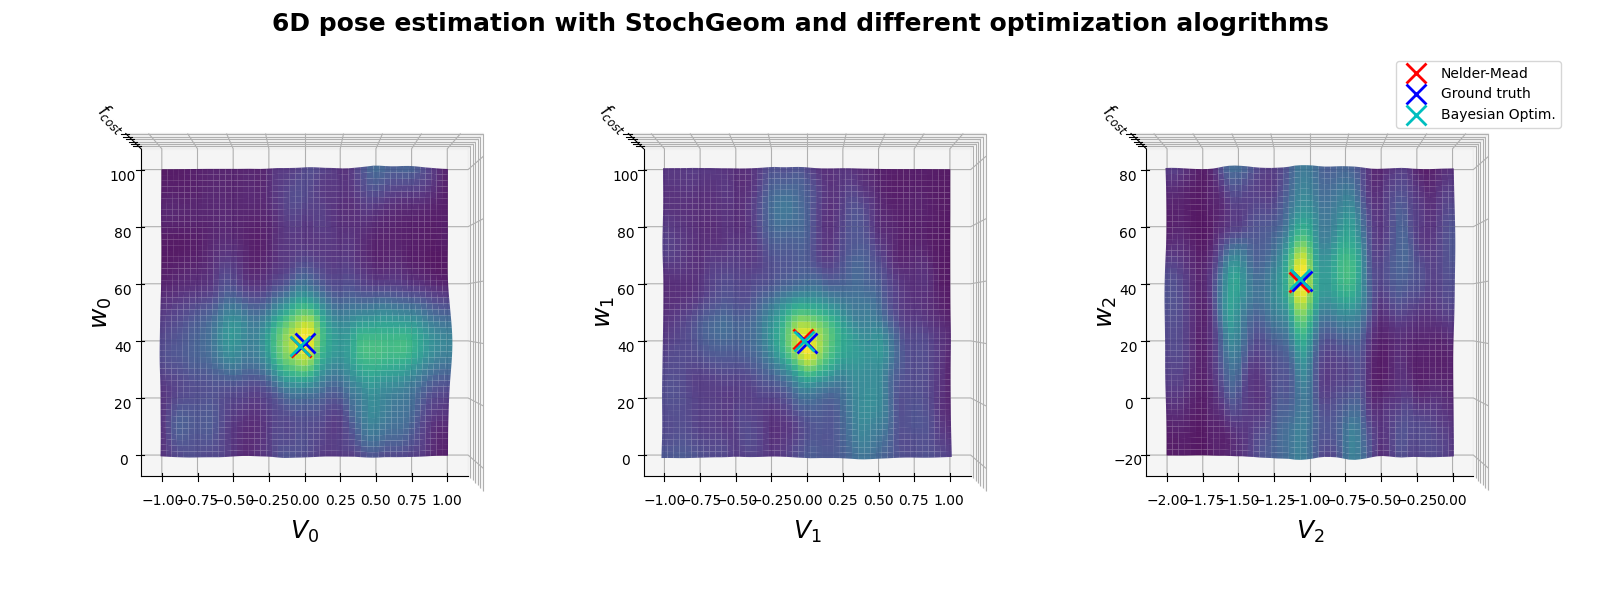

In [32]:
# plot results
fig, axes = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(16, 6))
for result in sorted(results):
    k, cost_surface, alpha_opt_z, true_pose_z, bayes_z, guess_z = result
    
    # interpolate and plot cost surface
    # V_range = np.linspace(-2.5, 2.5, 50)
    # w_range = np.linspace(-50, 150, 50)
    V_range = np.linspace(-1, 1, 50)
    w_range = np.linspace(0, 100, 50)
    if k==2:
        V_range = np.linspace(-2, 0, 50)
        w_range = np.linspace(-20, 80, 50)


    V_mesh, w_mesh = np.meshgrid(V_range, w_range)
    axes[k].plot_surface(V_mesh, w_mesh, cost_surface.T, cmap='viridis', alpha=0.9)

    # plot markers
    axes[k].plot(alpha_opt.x[:3][k], alpha_opt.x[3:][k], alpha_opt_z, 'rx', markersize=15, mew=2, zorder=5, label="Nelder-Mead")
    axes[k].plot(true_pose[:3][k], true_pose[3:][k], true_pose_z, 'bx', markersize=15, mew=2, zorder=5, label="Ground truth")
    axes[k].plot(best_alpha[:3][k], best_alpha[3:][k], bayes_z, 'cx', markersize=15, mew=2, zorder=5, label="Bayesian Optim.")
    # axes[k].plot(x0_probe[:3][k], x0_probe[3:][k], guess_z, 'mx', markersize=10, zorder=5)

    axes[k].set_xlabel(rf"$V_{k}$", fontweight='bold', fontsize=18, labelpad=15)
    axes[k].set_ylabel(rf'$w_{k}$', fontweight='bold', fontsize=18)
    axes[k].set_zlabel(r'$f_{cost}$', fontweight='bold', fontsize=12, labelpad=-8)
    # axes[k].set_title(rf'$V_{k} x w{k}$ of 6D pose')
    axes[k].view_init(azim=-90, elev=90)
        # axes[k].set_xticklabels(['' if i % 2 == 0 else label.get_text() for i, label in enumerate(axes[k].get_xticklabels())])
    axes[k].set_zticklabels(['' for i, label in enumerate(axes[k].get_zticklabels())])
    
    
    

plt.suptitle(r'6D pose estimation with StochGeom and different optimization alogrithms', weight='bold', fontsize=18)
plt.tight_layout()
plt.legend()
plt.subplots_adjust(wspace=-0.11)
plt.show()



/tmp/ipykernel_651/2509384060.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[k].set_xticklabels(['' if i % 2 == 0 else label.get_text() for i, label in enumerate(axes[k].get_xticklabels())])
/tmp/ipykernel_651/2509384060.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[k].set_zticklabels(['' for i, label in enumerate(ax.get_xticklabels())])
/tmp/ipykernel_651/2509384060.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[k].set_xticklabels(['' if i % 2 == 0 else label.get_text() for i, label in enumerate(axes[k].get_xticklabels())])
/tmp/ipykernel_651/2509384060.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[k].set_ztic

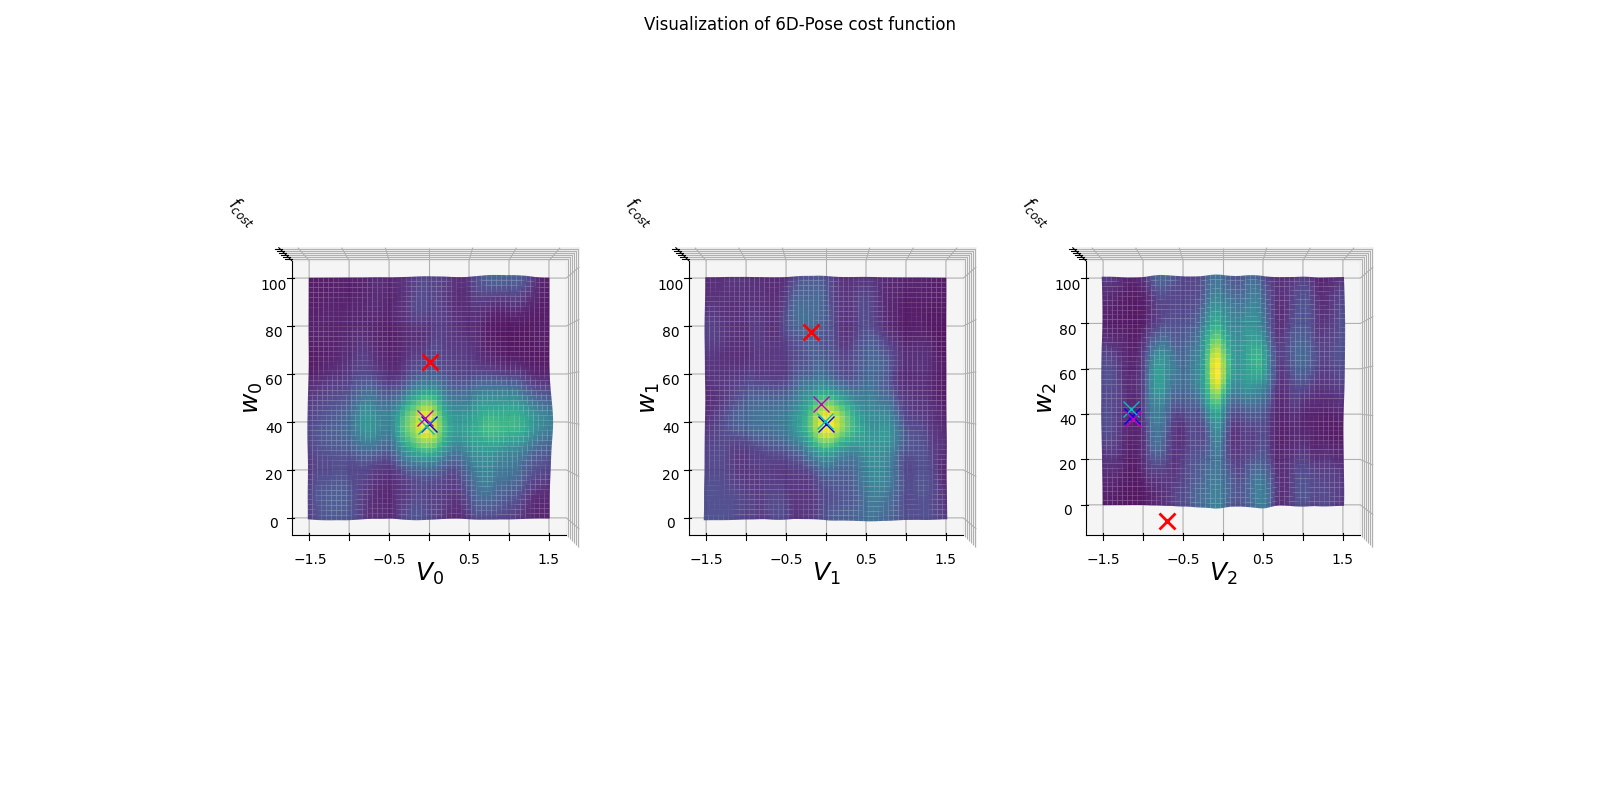

In [113]:
# plot results
fig, axes = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(16,8))
for result in sorted(results):
    k, cost_surface, alpha_opt_z, true_pose_z, bayes_z, guess_z = result
    
    # interpolate and plot cost surface
    V_range = np.linspace(-1.5, 1.5, 50)
    w_range = np.linspace(0, 100, 50)
    V_mesh, w_mesh = np.meshgrid(V_range, w_range)
    axes[k].plot_surface(V_mesh, w_mesh, cost_surface.T, cmap='viridis', alpha=0.9)

    # plot markers
    axes[k].plot(alpha_opt.x[:3][k], alpha_opt.x[3:][k], alpha_opt_z, 'rx', markersize=11, mew=2, zorder=5)
    axes[k].plot(true_pose[:3][k], true_pose[3:][k], true_pose_z, 'bx', markersize=11, zorder=5)
    axes[k].plot(best_alpha[:3][k], best_alpha[3:][k], bayes_z, 'cx', markersize=11, zorder=5)
    axes[k].plot(x0_probe[:3][k], x0_probe[3:][k], guess_z, 'mx', markersize=11, zorder=5)

    axes[k].set_xlabel(rf"$V_{k}$", fontweight='bold', fontsize=18)
    axes[k].set_ylabel(rf'$w_{k}$', fontweight='bold', fontsize=18)
    axes[k].set_zlabel(r'$f_{cost}$', fontweight='bold', fontsize=12)
    # axes[k].set_title(rf'$V_{k} x w{k}$ of 6D pose')
    axes[k].view_init(azim=-90, elev=90)
    
    axes[k].set_xticklabels(['' if i % 2 == 0 else label.get_text() for i, label in enumerate(axes[k].get_xticklabels())])
    axes[k].set_zticklabels(['' for i, label in enumerate(ax.get_xticklabels())])
    

plt.suptitle('Visualization of 6D-Pose cost function')
plt.tight_layout()
plt.subplots_adjust(wspace=-0.11)
plt.show()

In [73]:
float('-1.0')

-1.0

### Metrics

In [12]:
# convert to degrees
neldm_pose = np.concatenate([alpha_opt.x[:3]*(180/np.pi), alpha_opt.x[3:]])
true_pose = np.concatenate([true_pose[:3]*(180/np.pi), true_pose[3:]])
bayes_pose = np.concatenate([best_alpha[:3]*(180/np.pi), best_alpha[3:]])

In [ ]:
np.set_printoptions(suppress=True)
np.set_printoptions(formatter={'float': lambda x: "{0:2.4f}".format(x)})

print(f'true pose:   {true_pose}')
print(f'nelder mead: {neldm_pose}')
print(f'bayes: {bayes_pose}')
radar_plot(neldm_pose, true_pose)
radar_plot(bayes_pose, true_pose)
# print()
# true_pose[:3][k], true_pose[3:][k], true_pose_z, 'mx', markersize=10, zorder=5)
# best_alpha[:3][k], best_alpha[3:][k], bayes_z, 'cx', markersize=10, zorder=5)
